In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

import KeypointDetectionModel
import random

import os
from matplotlib import pyplot as plt
import Augment
import imageProcessing as ip
import csv

from Config import Config

/Users/julienstal/Library/Python/3.9/lib/python/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def split_data(data, test_size=0.2, random_seed=None):
    """
    Splits a list of dictionaries into training and test datasets.
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [4]:
# Open the CSV file and read its contents into a dictionary
# The stored data is: picture_name, x1, y1, x2, y2 
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)
print(len(train_data), len(test_data))

1919 480


In [5]:
image_names = [filename for filename in os.listdir(Config.images_folder_path) if filename.endswith(".jpg") or filename.endswith(".png")]

In [6]:
# Set the device to MPS (Metal Performance Shaders). If non-mac usage, try cuda
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


In [7]:
kpd_model = KeypointDetectionModel.KeypointDetectionModel().to(device)

KeypointDetectionModel.train_kpd_model(kpd_model, train_data, test_data, 50, 100, 250)

Epoch 0: test loss = 0.1299637109041214, lr = 9.900000000000001e-05
Epoch 50: test loss = 0.006719456985592842, lr = 5.9895600646616125e-05
Epoch 100: test loss = 0.0033381283283233643, lr = 3.62372017860497e-05
Epoch 150: test loss = 0.0031358860433101654, lr = 2.1923726936647233e-05
Epoch 200: test loss = 0.0031994134187698364, lr = 1.326398781093821e-05


In [8]:
import ConfidenceModel

kpd_model.eval()
conf_model = ConfidenceModel.ConfidenceModel().to(device)

ConfidenceModel.train_conf_model(conf_model, kpd_model, train_data, test_data, 50, 100, 41, feedback_rate=10)

Epoch 0: test loss = 1.0355512131354772e-05, lr = 9.9e-06
Epoch 10: test loss = 1.8299981093150564e-05, lr = 8.953382542587162e-06
Epoch 20: test loss = 1.0584070878394414e-05, lr = 8.097278682212583e-06
Epoch 30: test loss = 0.00010068479605251923, lr = 7.323033696543972e-06
Epoch 40: test loss = 6.3128081819741055e-06, lr = 6.622820409839832e-06


Confident predictions:
Error estimation =  0.0019032657146453857


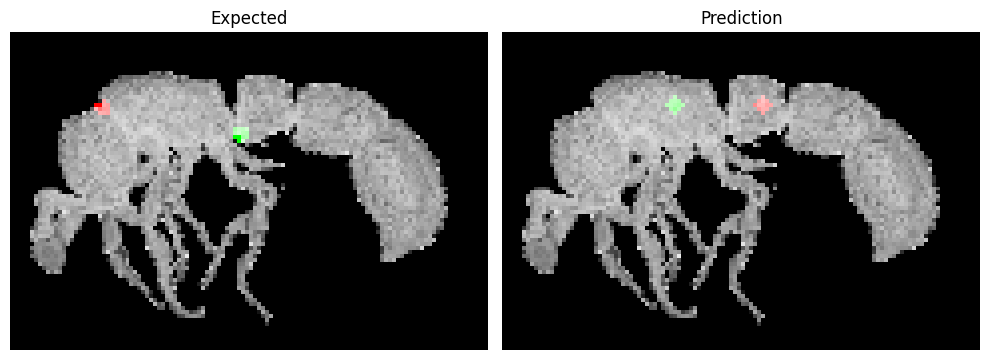

Error estimation =  0.0014461465179920197


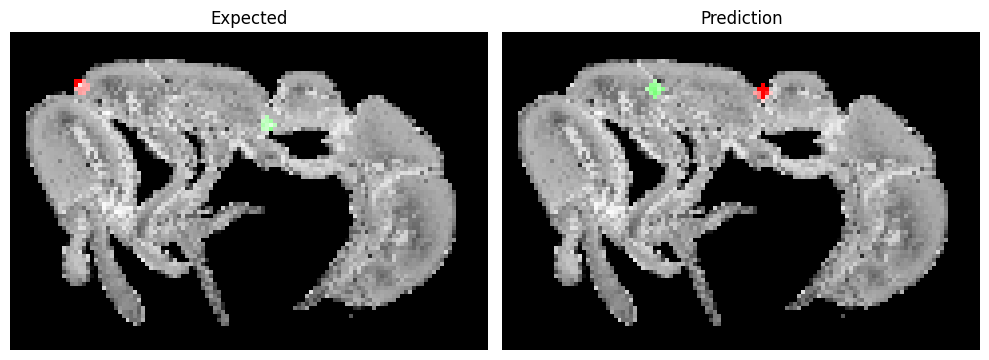

Error estimation =  0.0012218663468956947


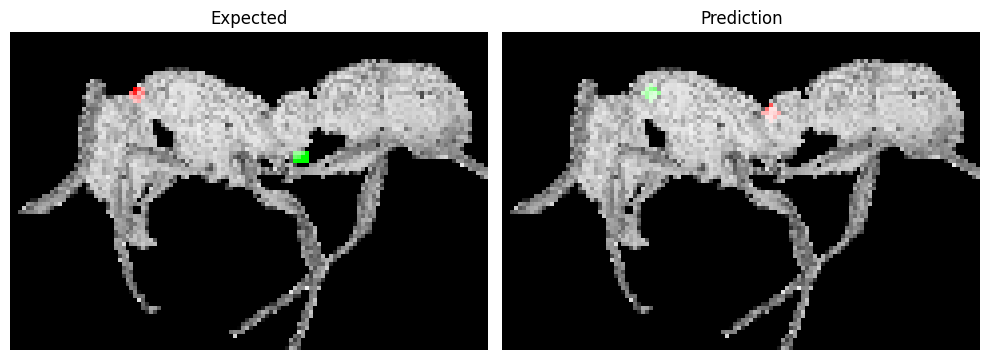

Error estimation =  0.0015135444700717926


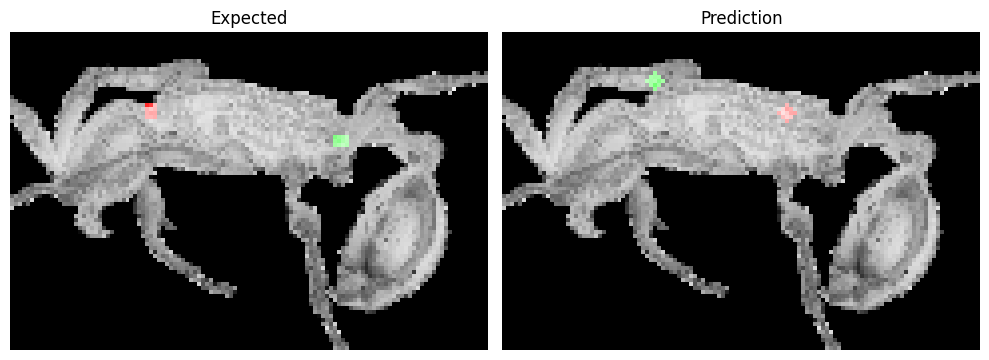

Error estimation =  0.0017794258892536163


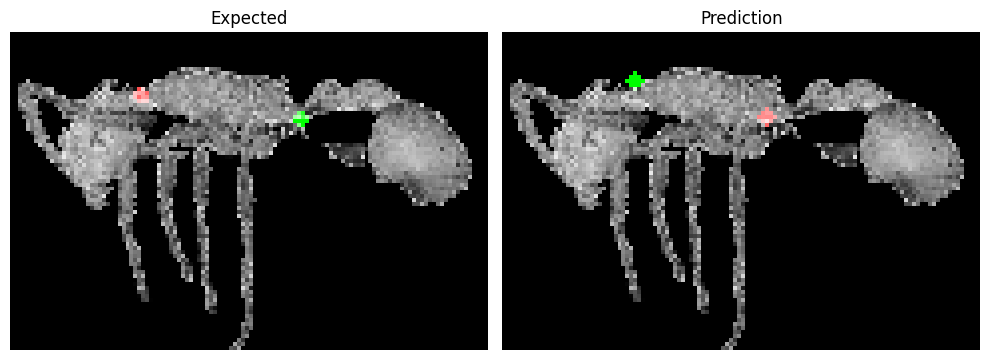

Error estimation =  0.0012379270046949387


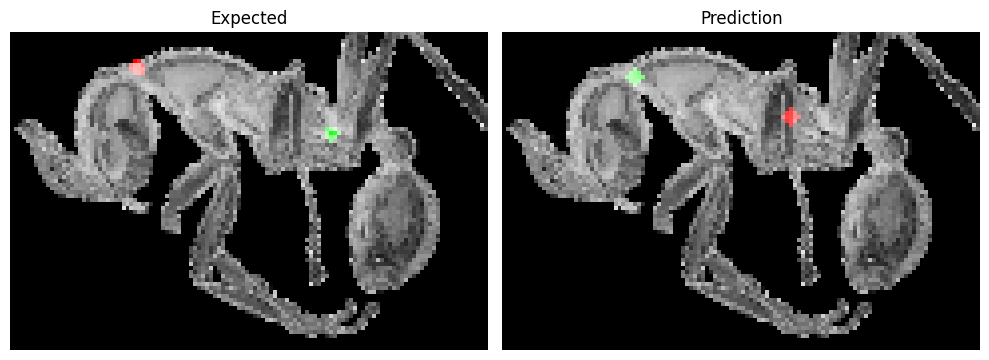

Error estimation =  0.0008056666702032089


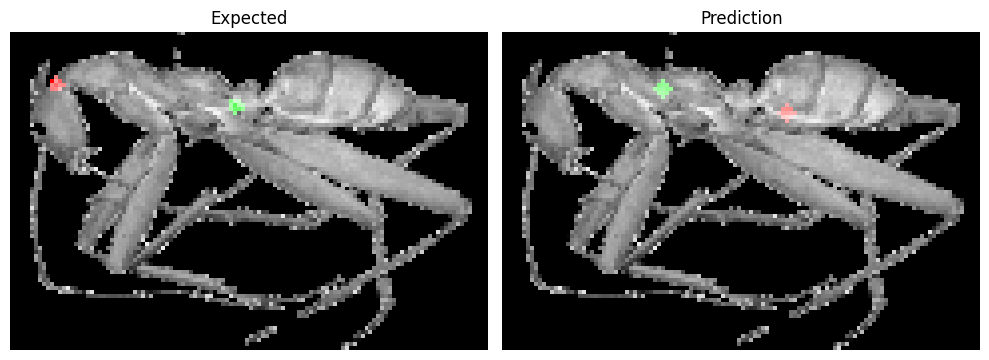

Error estimation =  0.0009856075048446655


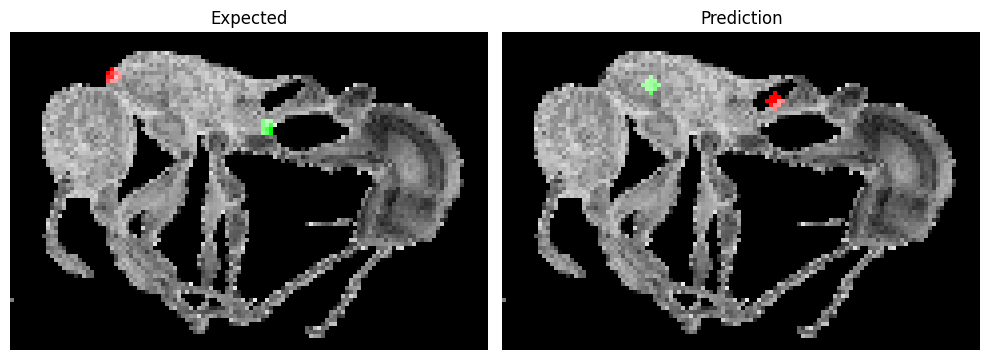

Error estimation =  0.0016767336055636406


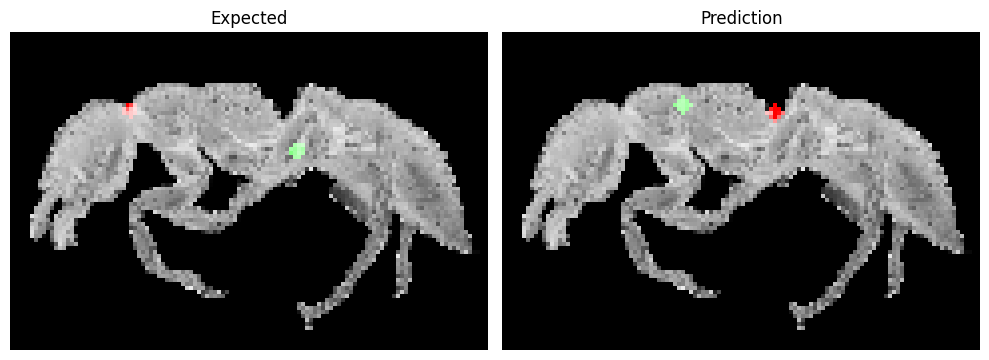

In [9]:
kpd_model.eval()
conf_model.eval()

print("Confident predictions:")
KeypointDetectionModel.plot_model_prediction(kpd_model, test_data, 50, conf_model = conf_model, error_estimation_interval= [-1, 0.002],augment_images=False, device="mps")

Non-confident predictions:
Error estimation =  0.005179696716368198


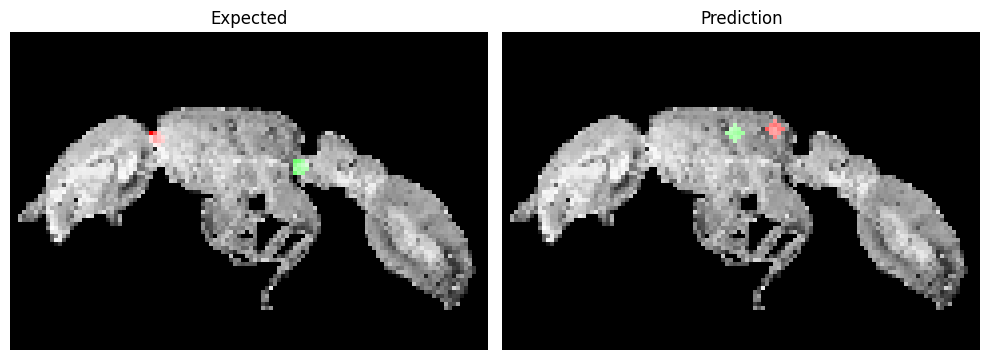

Error estimation =  0.005032524466514587


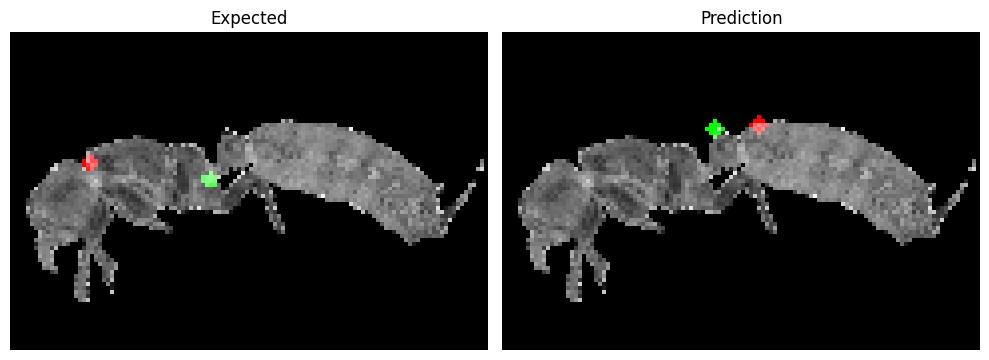

In [10]:
print("Non-confident predictions:")
KeypointDetectionModel.plot_model_prediction(kpd_model, test_data, 50, conf_model = conf_model, error_estimation_interval= [0.005, 1],augment_images=False, device="mps")